<a href="https://colab.research.google.com/github/JoseFranUdea/Proyecto_Fundamentos_Deep_Learning/blob/main/Copia_de_Modelo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulos a utilizar

In [1]:
from tensorflow.keras.utils import to_categorical
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from skimage import exposure
import cv2 as cv
import os
import itertools
import seaborn as sns
import os
import multiprocessing as mproc
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
import os
from matplotlib.pyplot import figure

from tqdm import tqdm
%matplotlib inline

print("ejecutado")

ejecutado


In [2]:
#Uso de GPU
import tensorflow as tf

gpucheck = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpucheck:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Name: /physical_device:GPU:0   Type: GPU


True

In [3]:
from google.colab import drive
import shutil
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
#Cargar variables

import pickle
# Cargar las variables desde el archivo
with open('/content/drive/MyDrive/variables.pkl', 'rb') as f:
    X,Y,Y64,trainxNdf,trainx,train_dir,test_dir,df,train_files,train_image,trainxN,direccion,TARGET_SIZE,BATCH_SIZE,EPOCHS,DATA_LIMIT = pickle.load(f)


**Comprobamos las dimensiones de las imágenes**

In [5]:
X.shape , Y64.shape, trainxNdf.shape 

((4125, 128, 128, 3), (4125, 6), (4125, 7))

**Dividimos nuestros datos**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y64, test_size=0.1)

In [7]:
#Comprobamos el tamaño de de nuestros datos de test
X_test.shape , y_test.shape

((413, 128, 128, 3), (413, 6))

# Definimos la estructura de nuestro Modelo_1

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(TARGET_SIZE,TARGET_SIZE,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 32)        0

**Entrenamos nuestro Modelo_1**

In [11]:
EPOCHS=10

In [12]:
model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), batch_size=BATCH_SIZE)
score = model.evaluate(X_test, y_test)
print("Rendimiento:", score)

Epoch 1/10
58/58 [==============================] - 3s 44ms/step - loss: 0.4727 - accuracy: 0.2608 - val_loss: 0.4838 - val_accuracy: 0.2978
Epoch 2/10
58/58 [==============================] - 2s 33ms/step - loss: 0.4663 - accuracy: 0.2557 - val_loss: 0.4791 - val_accuracy: 0.2978
Epoch 3/10
58/58 [==============================] - 2s 31ms/step - loss: 0.4557 - accuracy: 0.2761 - val_loss: 0.4407 - val_accuracy: 0.3245
Epoch 4/10
58/58 [==============================] - 2s 30ms/step - loss: 0.4407 - accuracy: 0.3063 - val_loss: 0.4306 - val_accuracy: 0.3196
Epoch 5/10
58/58 [==============================] - 2s 31ms/step - loss: 0.4392 - accuracy: 0.3098 - val_loss: 0.4134 - val_accuracy: 0.3414
Epoch 6/10
58/58 [==============================] - 2s 35ms/step - loss: 0.4316 - accuracy: 0.3225 - val_loss: 0.4159 - val_accuracy: 0.3535
Epoch 7/10
58/58 [==============================] - 2s 34ms/step - loss: 0.4273 - accuracy: 0.3421 - val_loss: 0.4051 - val_accuracy: 0.3729
Epoch 8/10
58

# Verificamos las etiquetas de nuestro X_test

**Debido a que nuestro X_test fue seleccionado al azar debemos verificar a que etiqueta pertenecen**

In [13]:
#Obtenemos un dataframe pero solo de la parte de test
#Hay que ordenarlo porque queda desordenado

from tensorflow.keras.preprocessing import image
import os

direccion_test=[]
dataframe_test = []
img_comprobacion=[]

for i in tqdm(range(len(trainx))):

        img_path = os.path.join(train_dir, trainx['image'][i])
        
        #Check if the image file exists
        if not os.path.isfile(img_path):
            print(f"Imagen no encontrada {img_path}. Saltando a la siguiente imagen.")
            continue
        
        img = image.load_img(img_path, target_size=(TARGET_SIZE, TARGET_SIZE, 3))
        img = image.img_to_array(img)
        img = img / 255

        for j in range(len(X_test)):
         if np.array_equal(img, X_test[j]):
            direccion_test.append(img_path)
            dataframe_test.append(trainx.iloc[i])
            img_comprobacion.append(img)  #img_comprobacion va igual que dataframe_test
            break #Esto es para que no se repita

dataframeN_test = pd.DataFrame(dataframe_test) 
img_comprobacion=np.array(img_comprobacion)

#Hay que encontrar donde image_path es igual, ahí encontraremos

  0%|          | 15/12000 [00:27<1:59:00,  1.68it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/802962dc3ecdbb8d.jpg. Saltando a la siguiente imagen.


  0%|          | 17/12000 [00:28<1:30:10,  2.21it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/802b34badefa2ed0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/802b59956a7aa5e7.jpg. Saltando a la siguiente imagen.


  0%|          | 21/12000 [00:29<1:13:50,  2.70it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8030a3a79fca6abb.jpg. Saltando a la siguiente imagen.


  0%|          | 35/12000 [00:35<1:31:53,  2.17it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/804e1eda54919fbb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/804e673e9ec3d12b.jpg. Saltando a la siguiente imagen.


  0%|          | 50/12000 [00:42<1:35:03,  2.10it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/80769797ce42f658.jpg. Saltando a la siguiente imagen.


  0%|          | 56/12000 [00:44<1:35:57,  2.07it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/807f3b90f2a315da.jpg. Saltando a la siguiente imagen.


  0%|          | 58/12000 [00:45<1:17:26,  2.57it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/80825b2e837f697d.jpg. Saltando a la siguiente imagen.


  1%|          | 143/12000 [01:29<1:49:55,  1.80it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/80d72f999a956d86.jpg. Saltando a la siguiente imagen.


  2%|▏         | 185/12000 [01:49<1:50:45,  1.78it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/812a9ac1796bf5c3.jpg. Saltando a la siguiente imagen.


  2%|▏         | 197/12000 [01:55<1:54:23,  1.72it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8152cfbd5a28b5d2.jpg. Saltando a la siguiente imagen.


  2%|▏         | 203/12000 [01:57<1:33:49,  2.10it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/816b93c24a07f6de.jpg. Saltando a la siguiente imagen.


  2%|▏         | 214/12000 [02:03<1:50:07,  1.78it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8181321fe6f2cf27.jpg. Saltando a la siguiente imagen.


  2%|▏         | 244/12000 [02:17<1:33:51,  2.09it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/81a063b69c99ed9e.jpg. Saltando a la siguiente imagen.


  2%|▏         | 256/12000 [02:23<1:35:59,  2.04it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/81a63d7ef8245a72.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/81a8f5d54427c87f.jpg. Saltando a la siguiente imagen.


  2%|▏         | 270/12000 [02:29<1:41:09,  1.93it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/81b4639b9c72790f.jpg. Saltando a la siguiente imagen.


  2%|▏         | 275/12000 [02:32<1:43:25,  1.89it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/81b74b16fc89f80e.jpg. Saltando a la siguiente imagen.


  2%|▏         | 279/12000 [02:33<1:32:52,  2.10it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/81bc253f7d07782a.jpg. Saltando a la siguiente imagen.


  2%|▏         | 284/12000 [02:36<1:53:24,  1.72it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/81bf24c79372651d.jpg. Saltando a la siguiente imagen.


  3%|▎         | 331/12000 [03:02<1:44:37,  1.86it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/81ecf08e963e1f83.jpg. Saltando a la siguiente imagen.


  3%|▎         | 357/12000 [03:15<1:32:51,  2.09it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/82157fc7bc832cca.jpg. Saltando a la siguiente imagen.


  3%|▎         | 359/12000 [03:15<1:10:17,  2.76it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8219aa662e8fd59d.jpg. Saltando a la siguiente imagen.


  3%|▎         | 368/12000 [03:19<1:25:42,  2.26it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8258bf3ade20f4f0.jpg. Saltando a la siguiente imagen.


  3%|▎         | 398/12000 [03:33<1:34:30,  2.05it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/82ac2520151ffb7f.jpg. Saltando a la siguiente imagen.


  3%|▎         | 400/12000 [03:33<1:10:50,  2.73it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/82add70df6ab2854.jpg. Saltando a la siguiente imagen.


  4%|▎         | 437/12000 [03:52<1:31:17,  2.11it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/82ec9b372f852f18.jpg. Saltando a la siguiente imagen.


  4%|▍         | 450/12000 [03:58<1:39:19,  1.94it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/82ff47b955d07490.jpg. Saltando a la siguiente imagen.


  4%|▍         | 471/12000 [04:08<1:44:01,  1.85it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/833cad8178db251f.jpg. Saltando a la siguiente imagen.


  4%|▍         | 478/12000 [04:11<1:28:46,  2.16it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8355b86a956bd16a.jpg. Saltando a la siguiente imagen.


  4%|▍         | 495/12000 [04:19<1:36:48,  1.98it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8381347b103f7f1d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/838183cd39b95b7a.jpg. Saltando a la siguiente imagen.


  4%|▍         | 530/12000 [04:35<1:39:06,  1.93it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/83a65ed1d28e9d83.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/83a75e2de0cb984b.jpg. Saltando a la siguiente imagen.


  5%|▍         | 544/12000 [04:41<1:29:58,  2.12it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/83b32ea384bf9634.jpg. Saltando a la siguiente imagen.


  5%|▍         | 598/12000 [05:08<1:28:38,  2.14it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8437f01fd3d20f26.jpg. Saltando a la siguiente imagen.


  5%|▌         | 613/12000 [05:14<1:26:50,  2.19it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/84713e23c0d37b6e.jpg. Saltando a la siguiente imagen.


  6%|▌         | 663/12000 [05:39<1:33:23,  2.02it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/84c2b48da27b8cf7.jpg. Saltando a la siguiente imagen.


  6%|▌         | 672/12000 [05:43<1:26:04,  2.19it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/84cf8c8fd5978b81.jpg. Saltando a la siguiente imagen.


  6%|▌         | 693/12000 [05:53<1:42:02,  1.85it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/84e965a9b7b24b54.jpg. Saltando a la siguiente imagen.


  6%|▌         | 695/12000 [05:53<1:13:00,  2.58it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/84ed2c342dfd4b0b.jpg. Saltando a la siguiente imagen.


  6%|▌         | 703/12000 [05:57<1:24:43,  2.22it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/84f26d8b126fe3a8.jpg. Saltando a la siguiente imagen.


  6%|▌         | 709/12000 [05:59<1:35:14,  1.98it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/84f81ac3c5ed6566.jpg. Saltando a la siguiente imagen.


  6%|▌         | 748/12000 [06:19<1:35:46,  1.96it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8541eaf0b42cdbe6.jpg. Saltando a la siguiente imagen.


  6%|▋         | 762/12000 [06:25<1:41:39,  1.84it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/85626bc3f479a16c.jpg. Saltando a la siguiente imagen.


  6%|▋         | 768/12000 [06:28<1:37:23,  1.92it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8568b2e313eefc12.jpg. Saltando a la siguiente imagen.


  7%|▋         | 798/12000 [06:42<1:31:18,  2.04it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/85922d3ebe65d8a1.jpg. Saltando a la siguiente imagen.


  7%|▋         | 833/12000 [06:58<1:27:26,  2.13it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/85b37b284f8ec22b.jpg. Saltando a la siguiente imagen.


  7%|▋         | 890/12000 [07:27<1:21:22,  2.28it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/85e53e8786664a9d.jpg. Saltando a la siguiente imagen.


  7%|▋         | 894/12000 [07:28<1:16:50,  2.41it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/85e834be8e733239.jpg. Saltando a la siguiente imagen.


  8%|▊         | 901/12000 [07:32<1:39:52,  1.85it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/85ec3f0705065df9.jpg. Saltando a la siguiente imagen.


  8%|▊         | 905/12000 [07:33<1:21:02,  2.28it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/85ee63732c8cf3c0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/85f03e6f8186ac9e.jpg. Saltando a la siguiente imagen.


  8%|▊         | 950/12000 [07:55<1:41:36,  1.81it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/86977a4aa7a4d25a.jpg. Saltando a la siguiente imagen.


  8%|▊         | 980/12000 [08:10<1:33:50,  1.96it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/86d647d50695364f.jpg. Saltando a la siguiente imagen.


  9%|▊         | 1041/12000 [08:39<1:23:32,  2.19it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8783d06a2f3c8d76.jpg. Saltando a la siguiente imagen.


  9%|▉         | 1054/12000 [08:45<1:25:01,  2.15it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/87925034ff8b833e.jpg. Saltando a la siguiente imagen.


  9%|▉         | 1079/12000 [08:57<1:25:31,  2.13it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/87b3d6c28caade82.jpg. Saltando a la siguiente imagen.


  9%|▉         | 1106/12000 [09:10<1:43:14,  1.76it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/87eb994599da9047.jpg. Saltando a la siguiente imagen.


  9%|▉         | 1125/12000 [09:19<1:23:02,  2.18it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/881b4dba7731b362.jpg. Saltando a la siguiente imagen.


 10%|█         | 1232/12000 [10:12<1:31:54,  1.95it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/892ed2119c39797b.jpg. Saltando a la siguiente imagen.


 10%|█         | 1235/12000 [10:13<1:14:09,  2.42it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8935609715f7d28b.jpg. Saltando a la siguiente imagen.


 10%|█         | 1249/12000 [10:19<1:21:31,  2.20it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/896b3f80236d761b.jpg. Saltando a la siguiente imagen.


 10%|█         | 1256/12000 [10:22<1:20:29,  2.22it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8986d59361edf268.jpg. Saltando a la siguiente imagen.


 11%|█         | 1283/12000 [10:34<1:22:53,  2.15it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/89a567979824e9d6.jpg. Saltando a la siguiente imagen.


 11%|█         | 1296/12000 [10:41<1:33:26,  1.91it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/89b57d953cda1189.jpg. Saltando a la siguiente imagen.


 11%|█         | 1299/12000 [10:41<1:12:00,  2.48it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/89b949916b36cb9c.jpg. Saltando a la siguiente imagen.


 11%|█         | 1306/12000 [10:44<1:21:55,  2.18it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/89becd60a683a29f.jpg. Saltando a la siguiente imagen.


 11%|█         | 1338/12000 [11:01<1:36:30,  1.84it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a0be55d81f4bf0c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a0d7cad7053f18d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a0f52e99d52cd72.jpg. Saltando a la siguiente imagen.


 11%|█         | 1342/12000 [11:01<51:29,  3.45it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a1a97abda0b4a7a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a1b387a99311bf5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a1e845e8e2ebf2c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a1eaaf015654fad.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a1ef092b3b6a6d2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a1f1cdc4f283d33.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a27d495855e55da.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a2d598f2ec436e6.jpg. Saltando a la si

 11%|█▏        | 1357/12000 [11:02<16:32, 10.73it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a4772d191dcd969.jpg. Saltando a la siguiente imagen.


 11%|█▏        | 1360/12000 [11:03<26:59,  6.57it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a57ba815538fce1.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a5a47354d3d5517.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a5c2ed32fdb6882.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a607e82611eb7f9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a62b42b56976baa.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a695cd7e4533513.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a6aa690e59795ab.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a70aa5145aeb3af.jpg. Saltando a la si

 11%|█▏        | 1373/12000 [11:03<15:30, 11.42it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a7ad65bd849d505.jpg. Saltando a la siguiente imagen.


 11%|█▏        | 1375/12000 [11:04<18:50,  9.40it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a8437e6c25f2bc9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a8591d2e865f1db.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a86d49f916a2b6d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a9138ebc3a68f8d.jpg. Saltando a la siguiente imagen.


 12%|█▏        | 1380/12000 [11:04<18:11,  9.73it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a954b82bf81f2bc.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a956ab79447896e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a95fd2d84553355.jpg. Saltando a la siguiente imagen.


 12%|█▏        | 1385/12000 [11:06<26:32,  6.67it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a972fc8126ef136.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a993a71634e7327.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a9a1e72a7ac507d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a9e59da6b61608f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a9e5c177d273168.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a9ed96e66850ba5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8a9f2f485e20ade9.jpg. Saltando a la siguiente imagen.


 12%|█▏        | 1400/12000 [11:10<1:04:45,  2.73it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8aa7d6526ba664b2.jpg. Saltando a la siguiente imagen.


 12%|█▏        | 1405/12000 [11:11<1:10:01,  2.52it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8ab073c5dd79a2a8.jpg. Saltando a la siguiente imagen.


 12%|█▏        | 1438/12000 [11:27<1:25:22,  2.06it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8ad786d2d6c2caca.jpg. Saltando a la siguiente imagen.


 12%|█▏        | 1452/12000 [11:33<1:24:02,  2.09it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8af52f087f712a0d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8af578ce650e91b1.jpg. Saltando a la siguiente imagen.


 12%|█▏        | 1471/12000 [11:41<1:21:02,  2.17it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8b432b365c7e153a.jpg. Saltando a la siguiente imagen.


 12%|█▏        | 1481/12000 [11:46<1:19:57,  2.19it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8b5b10f0bb2aab27.jpg. Saltando a la siguiente imagen.


 13%|█▎        | 1529/12000 [12:09<1:26:02,  2.03it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8bc27bdbdf8092a0.jpg. Saltando a la siguiente imagen.


 13%|█▎        | 1570/12000 [12:28<1:15:15,  2.31it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8c2bb1e6bc87329c.jpg. Saltando a la siguiente imagen.


 13%|█▎        | 1575/12000 [12:30<1:13:14,  2.37it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8c42bd2ed8f05cab.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8c4a34369a71ebdc.jpg. Saltando a la siguiente imagen.


 13%|█▎        | 1581/12000 [12:32<1:09:48,  2.49it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8c6e3d86f81e111f.jpg. Saltando a la siguiente imagen.


 13%|█▎        | 1585/12000 [12:34<1:15:56,  2.29it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8c7a63253ad82ece.jpg. Saltando a la siguiente imagen.


 13%|█▎        | 1607/12000 [12:45<1:32:29,  1.87it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8ca723999d1f634c.jpg. Saltando a la siguiente imagen.


 14%|█▎        | 1621/12000 [12:52<1:27:00,  1.99it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8cbbfc83d31ad890.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8cbcb762ad3be880.jpg. Saltando a la siguiente imagen.


 14%|█▎        | 1626/12000 [12:53<1:11:27,  2.42it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8cc713b04bb158fe.jpg. Saltando a la siguiente imagen.


 14%|█▍        | 1675/12000 [13:19<1:21:50,  2.10it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8d4c3e7bc3ae8c88.jpg. Saltando a la siguiente imagen.


 14%|█▍        | 1725/12000 [13:43<1:18:17,  2.19it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8dad31a8e26bc56a.jpg. Saltando a la siguiente imagen.


 14%|█▍        | 1729/12000 [13:45<1:09:08,  2.48it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8db1475933aabcc2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8db16ec38c8bc996.jpg. Saltando a la siguiente imagen.


 14%|█▍        | 1733/12000 [13:46<51:44,  3.31it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8db43550701f63af.jpg. Saltando a la siguiente imagen.


 14%|█▍        | 1739/12000 [13:48<1:14:03,  2.31it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8dbb1ad3b44b684a.jpg. Saltando a la siguiente imagen.


 15%|█▍        | 1770/12000 [14:04<1:41:19,  1.68it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8df430d741d903af.jpg. Saltando a la siguiente imagen.


 15%|█▍        | 1792/12000 [14:14<1:34:59,  1.79it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8e6e6591da299c47.jpg. Saltando a la siguiente imagen.


 15%|█▌        | 1825/12000 [14:31<1:26:04,  1.97it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8e9e7eaa34250b71.jpg. Saltando a la siguiente imagen.


 15%|█▌        | 1839/12000 [14:37<1:20:52,  2.09it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8ec3a78dd5d15216.jpg. Saltando a la siguiente imagen.


 15%|█▌        | 1845/12000 [14:40<1:18:47,  2.15it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8ed47a5ca47c096d.jpg. Saltando a la siguiente imagen.


 15%|█▌        | 1847/12000 [14:40<1:03:21,  2.67it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8ed644869ee5d14b.jpg. Saltando a la siguiente imagen.


 16%|█▌        | 1863/12000 [14:48<1:27:47,  1.92it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8efc207070f3b9c9.jpg. Saltando a la siguiente imagen.


 16%|█▌        | 1890/12000 [15:01<1:19:53,  2.11it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8f3b45ca0c71673c.jpg. Saltando a la siguiente imagen.


 16%|█▌        | 1899/12000 [15:05<1:28:24,  1.90it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8f4f373c329cf060.jpg. Saltando a la siguiente imagen.


 16%|█▌        | 1927/12000 [15:19<1:40:23,  1.67it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8f9b3a381388ad9d.jpg. Saltando a la siguiente imagen.


 16%|█▌        | 1942/12000 [15:26<1:23:37,  2.00it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8fbc33c7895a330c.jpg. Saltando a la siguiente imagen.


 16%|█▌        | 1947/12000 [15:28<1:16:40,  2.19it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8fc3b16e36d0aac8.jpg. Saltando a la siguiente imagen.


 16%|█▋        | 1952/12000 [15:30<1:10:42,  2.37it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/8fc97529613d34b8.jpg. Saltando a la siguiente imagen.


 17%|█▋        | 1981/12000 [15:45<1:28:47,  1.88it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/900e32daa73987fc.jpg. Saltando a la siguiente imagen.


 17%|█▋        | 1988/12000 [15:47<1:13:10,  2.28it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/902b269c0ddbe3e5.jpg. Saltando a la siguiente imagen.


 17%|█▋        | 2065/12000 [16:25<1:18:08,  2.12it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/90bd638f9c32656c.jpg. Saltando a la siguiente imagen.


 17%|█▋        | 2068/12000 [16:26<1:08:12,  2.43it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/90c33a692df76827.jpg. Saltando a la siguiente imagen.


 17%|█▋        | 2071/12000 [16:28<1:03:11,  2.62it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/90c8697a931dd61f.jpg. Saltando a la siguiente imagen.


 17%|█▋        | 2077/12000 [16:30<1:10:51,  2.33it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/90ca1673f19c8f63.jpg. Saltando a la siguiente imagen.


 18%|█▊        | 2121/12000 [16:52<1:21:33,  2.02it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/90f6f2865a0f391d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/90f7e0c35d5a1f14.jpg. Saltando a la siguiente imagen.


 18%|█▊        | 2137/12000 [16:59<1:30:45,  1.81it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/91285b9fcae69493.jpg. Saltando a la siguiente imagen.


 18%|█▊        | 2140/12000 [17:00<1:16:06,  2.16it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/91356a847fc63656.jpg. Saltando a la siguiente imagen.


 18%|█▊        | 2166/12000 [17:12<1:26:59,  1.88it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/917a07d27abc9994.jpg. Saltando a la siguiente imagen.


 18%|█▊        | 2178/12000 [17:18<1:16:34,  2.14it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9187bc815e755a9c.jpg. Saltando a la siguiente imagen.


 18%|█▊        | 2186/12000 [17:21<1:15:26,  2.17it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/919ac10a5cf8ad7d.jpg. Saltando a la siguiente imagen.


 18%|█▊        | 2201/12000 [17:28<1:15:05,  2.17it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/91b4acd17962678d.jpg. Saltando a la siguiente imagen.


 18%|█▊        | 2203/12000 [17:29<1:01:16,  2.67it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/91bf6b8190637996.jpg. Saltando a la siguiente imagen.


 18%|█▊        | 2213/12000 [17:34<1:25:53,  1.90it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/91d0d190ffb486b3.jpg. Saltando a la siguiente imagen.


 19%|█▊        | 2226/12000 [17:40<1:29:08,  1.83it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/91e481df9e1b6a29.jpg. Saltando a la siguiente imagen.


 19%|█▊        | 2239/12000 [17:46<1:14:57,  2.17it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/91f0f0e4d11e1f36.jpg. Saltando a la siguiente imagen.


 19%|█▉        | 2256/12000 [17:54<1:26:13,  1.88it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/922b31bfa10e9b5c.jpg. Saltando a la siguiente imagen.


 19%|█▉        | 2301/12000 [18:17<1:16:40,  2.11it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/929b16251fcaafc4.jpg. Saltando a la siguiente imagen.


 19%|█▉        | 2311/12000 [18:20<1:14:16,  2.17it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/92a925c0f3ebe9e0.jpg. Saltando a la siguiente imagen.


 20%|█▉        | 2350/12000 [18:40<1:20:35,  2.00it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/92d85a6ba115dccd.jpg. Saltando a la siguiente imagen.


 20%|█▉        | 2362/12000 [18:46<1:20:08,  2.00it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/92e4c4964f8f370d.jpg. Saltando a la siguiente imagen.


 20%|█▉        | 2373/12000 [18:50<1:11:28,  2.24it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/92f37ac388c2d8dc.jpg. Saltando a la siguiente imagen.


 20%|██        | 2403/12000 [19:05<1:24:34,  1.89it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/937fbd80d80b093d.jpg. Saltando a la siguiente imagen.


 20%|██        | 2423/12000 [19:14<1:21:38,  1.96it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/93b2a2dec65c2b43.jpg. Saltando a la siguiente imagen.


 20%|██        | 2443/12000 [19:24<1:15:13,  2.12it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/93e59b85a78a16aa.jpg. Saltando a la siguiente imagen.


 21%|██        | 2471/12000 [19:39<1:17:43,  2.04it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/942d5a2933b7e8d8.jpg. Saltando a la siguiente imagen.


 21%|██        | 2498/12000 [19:52<1:18:12,  2.02it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/946cddd7342d58a1.jpg. Saltando a la siguiente imagen.


 21%|██        | 2501/12000 [19:53<1:02:46,  2.52it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/94793fc5b0ce7248.jpg. Saltando a la siguiente imagen.


 21%|██        | 2503/12000 [19:54<55:49,  2.84it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/947a4a17a5bdec11.jpg. Saltando a la siguiente imagen.


 21%|██        | 2526/12000 [20:05<1:15:55,  2.08it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/949a6a87356bc378.jpg. Saltando a la siguiente imagen.


 21%|██        | 2535/12000 [20:09<1:26:41,  1.82it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/949fcf6c2c649c4a.jpg. Saltando a la siguiente imagen.


 21%|██        | 2547/12000 [20:15<1:18:53,  2.00it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/94ac02feb507fc07.jpg. Saltando a la siguiente imagen.


 21%|██▏       | 2579/12000 [20:30<1:14:07,  2.12it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/94c8b450b075eded.jpg. Saltando a la siguiente imagen.


 22%|██▏       | 2585/12000 [20:33<1:15:39,  2.07it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/94ccde9c16ba2723.jpg. Saltando a la siguiente imagen.


 22%|██▏       | 2602/12000 [20:40<1:10:50,  2.21it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/94dbce4347a0b659.jpg. Saltando a la siguiente imagen.


 22%|██▏       | 2615/12000 [20:46<1:22:07,  1.90it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/94e4d8968d9bb499.jpg. Saltando a la siguiente imagen.


 22%|██▏       | 2663/12000 [21:09<1:11:28,  2.18it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/953537e2604edb38.jpg. Saltando a la siguiente imagen.


 22%|██▏       | 2672/12000 [21:14<1:23:28,  1.86it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9545afa1952a6e96.jpg. Saltando a la siguiente imagen.


 22%|██▏       | 2682/12000 [21:18<1:07:51,  2.29it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9552b13f9bba5920.jpg. Saltando a la siguiente imagen.


 22%|██▏       | 2697/12000 [21:25<1:29:30,  1.73it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/956a14cd75279a74.jpg. Saltando a la siguiente imagen.


 23%|██▎       | 2703/12000 [21:27<1:10:43,  2.19it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/956f3ad4c6a13493.jpg. Saltando a la siguiente imagen.


 23%|██▎       | 2765/12000 [21:58<1:06:36,  2.31it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/95af07eb0a583e51.jpg. Saltando a la siguiente imagen.


 23%|██▎       | 2796/12000 [22:14<1:22:53,  1.85it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/95c25b7a7d1a0695.jpg. Saltando a la siguiente imagen.


 23%|██▎       | 2799/12000 [22:15<1:09:59,  2.19it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/95c86878e7c2e764.jpg. Saltando a la siguiente imagen.


 24%|██▎       | 2824/12000 [22:27<1:17:06,  1.98it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/95df116a2a61fc29.jpg. Saltando a la siguiente imagen.


 24%|██▎       | 2835/12000 [22:32<1:13:02,  2.09it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/95e4f084be1eca9c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/95e633360a0fe539.jpg. Saltando a la siguiente imagen.


 24%|██▍       | 2865/12000 [22:46<1:13:36,  2.07it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/961668add989db16.jpg. Saltando a la siguiente imagen.


 24%|██▍       | 2873/12000 [22:50<1:17:35,  1.96it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/96299a350b35bb66.jpg. Saltando a la siguiente imagen.


 24%|██▍       | 2933/12000 [23:20<1:20:14,  1.88it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/969cc393c3526b1e.jpg. Saltando a la siguiente imagen.


 25%|██▌       | 3021/12000 [24:03<1:15:51,  1.97it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/97787ab88e81292f.jpg. Saltando a la siguiente imagen.


 25%|██▌       | 3035/12000 [24:10<1:19:34,  1.88it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/978b59b56a53e184.jpg. Saltando a la siguiente imagen.


 26%|██▌       | 3066/12000 [24:26<1:19:11,  1.88it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/97a9ee615cd53098.jpg. Saltando a la siguiente imagen.


 26%|██▌       | 3069/12000 [24:27<1:00:00,  2.48it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/97ae1a31133769cc.jpg. Saltando a la siguiente imagen.


 26%|██▌       | 3097/12000 [24:41<1:15:36,  1.96it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/97e5029339d7704e.jpg. Saltando a la siguiente imagen.


 26%|██▌       | 3100/12000 [24:42<1:01:29,  2.41it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/97f33fda98d82802.jpg. Saltando a la siguiente imagen.


 26%|██▌       | 3106/12000 [24:44<1:06:48,  2.22it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/97fd27d1d5189288.jpg. Saltando a la siguiente imagen.


 26%|██▌       | 3119/12000 [24:51<1:15:34,  1.96it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/98322eab16bef2c1.jpg. Saltando a la siguiente imagen.


 26%|██▌       | 3124/12000 [24:53<1:09:57,  2.11it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9837d2dad29bf009.jpg. Saltando a la siguiente imagen.


 26%|██▌       | 3141/12000 [25:01<1:17:08,  1.91it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/987934e3c4b5bca4.jpg. Saltando a la siguiente imagen.


 26%|██▋       | 3152/12000 [25:06<1:07:51,  2.17it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9894ad9bae345365.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9895cac82ffa849d.jpg. Saltando a la siguiente imagen.


 26%|██▋       | 3166/12000 [25:13<1:20:42,  1.82it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/98a81c358479bfcb.jpg. Saltando a la siguiente imagen.


 26%|██▋       | 3178/12000 [25:18<1:10:48,  2.08it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/98c639d63f9a8949.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3183/12000 [25:20<1:04:24,  2.28it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/98c9789dcb90d1b9.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3186/12000 [25:21<58:40,  2.50it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/98d8e3d2ce3074d9.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3192/12000 [25:24<1:03:52,  2.30it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/98e36081c71ebf8e.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3203/12000 [25:29<1:19:32,  1.84it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/98f4000fff7b8313.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3228/12000 [25:41<1:15:08,  1.95it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/998069d4d84aebed.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3230/12000 [25:42<56:00,  2.61it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/998257be202d9767.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3246/12000 [25:49<1:09:26,  2.10it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/99996f8d81594a3e.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3257/12000 [25:55<1:15:45,  1.92it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/99ae3b3272f26151.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3261/12000 [25:56<1:03:09,  2.31it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/99bc71b8c6794323.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3263/12000 [25:57<49:23,  2.95it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/99c367875e18b24b.jpg. Saltando a la siguiente imagen.


 27%|██▋       | 3288/12000 [26:09<1:18:20,  1.85it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/99f3639158699cd8.jpg. Saltando a la siguiente imagen.


 28%|██▊       | 3349/12000 [26:39<1:09:35,  2.07it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9ac3c5851b3d75c2.jpg. Saltando a la siguiente imagen.


 28%|██▊       | 3391/12000 [26:59<1:12:52,  1.97it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9b4924e4d0866feb.jpg. Saltando a la siguiente imagen.


 29%|██▊       | 3437/12000 [27:22<1:14:54,  1.91it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9be561de7c792420.jpg. Saltando a la siguiente imagen.


 29%|██▊       | 3443/12000 [27:24<1:07:33,  2.11it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9bf4c55a704d7524.jpg. Saltando a la siguiente imagen.


 29%|██▉       | 3454/12000 [27:29<1:09:02,  2.06it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9c240ccd9afdd296.jpg. Saltando a la siguiente imagen.


 29%|██▉       | 3474/12000 [27:38<1:07:32,  2.10it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9c79758f3cd43105.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9c7b9cab54be6900.jpg. Saltando a la siguiente imagen.


 29%|██▉       | 3480/12000 [27:40<58:14,  2.44it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9c8780f83917c7c7.jpg. Saltando a la siguiente imagen.


 29%|██▉       | 3496/12000 [27:48<1:07:18,  2.11it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9cb09eb2cabfc700.jpg. Saltando a la siguiente imagen.


 29%|██▉       | 3503/12000 [27:51<1:13:08,  1.94it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9cc1c295c5be3d34.jpg. Saltando a la siguiente imagen.


 29%|██▉       | 3506/12000 [27:52<58:55,  2.40it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9cc3797cdf3c0301.jpg. Saltando a la siguiente imagen.


 30%|██▉       | 3540/12000 [28:08<1:11:07,  1.98it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9d318966ec376b50.jpg. Saltando a la siguiente imagen.


 30%|██▉       | 3559/12000 [28:16<1:01:11,  2.30it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9d726222ad7ae196.jpg. Saltando a la siguiente imagen.


 30%|██▉       | 3576/12000 [28:24<1:16:29,  1.84it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9d986012da6c95fb.jpg. Saltando a la siguiente imagen.


 30%|███       | 3608/12000 [28:40<1:06:51,  2.09it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9dce6cac2bf08705.jpg. Saltando a la siguiente imagen.


 30%|███       | 3619/12000 [28:45<1:07:37,  2.07it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9dda402577d1c8da.jpg. Saltando a la siguiente imagen.


 30%|███       | 3627/12000 [28:56<1:37:05,  1.44it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9deb08a136da61b9.jpg. Saltando a la siguiente imagen.


 30%|███       | 3643/12000 [29:03<1:12:21,  1.93it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9e004fca3675d63c.jpg. Saltando a la siguiente imagen.


 30%|███       | 3646/12000 [29:04<58:38,  2.37it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9e0d961d1ebc7a88.jpg. Saltando a la siguiente imagen.


 30%|███       | 3650/12000 [29:06<57:10,  2.43it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9e187517126d597a.jpg. Saltando a la siguiente imagen.


 30%|███       | 3652/12000 [29:06<50:20,  2.76it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9e1f7cd66c1260ac.jpg. Saltando a la siguiente imagen.


 31%|███       | 3665/12000 [29:12<1:09:40,  1.99it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9e65bc327c19d229.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9e6878856b9cd1d8.jpg. Saltando a la siguiente imagen.


 31%|███       | 3668/12000 [29:13<44:33,  3.12it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9e6b2a936acf8542.jpg. Saltando a la siguiente imagen.


 31%|███       | 3697/12000 [29:27<1:21:11,  1.70it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9ea4d0d51595519f.jpg. Saltando a la siguiente imagen.


 31%|███       | 3724/12000 [29:40<1:13:40,  1.87it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9ee390fd18622795.jpg. Saltando a la siguiente imagen.


 31%|███       | 3736/12000 [29:45<1:02:00,  2.22it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9ef52b2fe0c4944a.jpg. Saltando a la siguiente imagen.


 31%|███       | 3739/12000 [29:46<51:09,  2.69it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9f047ac44a6a1f6d.jpg. Saltando a la siguiente imagen.


 31%|███       | 3749/12000 [29:51<1:06:48,  2.06it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9f23ef65613e8031.jpg. Saltando a la siguiente imagen.


 31%|███▏      | 3759/12000 [29:55<1:06:36,  2.06it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9f7e416776c810aa.jpg. Saltando a la siguiente imagen.


 31%|███▏      | 3770/12000 [30:00<1:00:51,  2.25it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9f946a2a2d38d5b4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9f99256166c89dd1.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3801/12000 [30:14<1:05:22,  2.09it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9fbc850a8e19f0f1.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3818/12000 [30:23<1:07:15,  2.03it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9fd8a0ed6cc0b352.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9fd9a3c371fc0a80.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3825/12000 [30:25<58:58,  2.31it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/9fff0cd05c433740.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3832/12000 [30:28<1:05:48,  2.07it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0105f6573dba19d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a01692bb4f4d1dec.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3840/12000 [30:31<1:00:10,  2.26it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0260ff0da9f525d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0281d97c3dadcab.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3850/12000 [30:35<1:06:40,  2.04it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0304ff9fc1f4b60.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3852/12000 [30:36<52:39,  2.58it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0332affc291d3d2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a03456cadad6da8e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a03497c399c9c7d9.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3857/12000 [30:37<40:12,  3.37it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0372db88e8b4a7e.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3873/12000 [30:45<1:13:43,  1.84it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0455f1334e5dec6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0479acf496dec16.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3882/12000 [30:48<56:39,  2.39it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a05587dd535c2b6a.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3889/12000 [30:51<59:57,  2.25it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a06896f6dd91e487.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3894/12000 [30:52<57:27,  2.35it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0759692b5cb7364.jpg. Saltando a la siguiente imagen.


 32%|███▏      | 3896/12000 [30:53<46:28,  2.91it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0786f831db76269.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a078976b5f86f1c0.jpg. Saltando a la siguiente imagen.


 32%|███▎      | 3900/12000 [30:54<45:00,  3.00it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a07995d4ded82d0e.jpg. Saltando a la siguiente imagen.


 33%|███▎      | 3915/12000 [31:01<1:02:46,  2.15it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0878e5e89c11fdb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a08795b81fd0be93.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0879d0d677be2c2.jpg. Saltando a la siguiente imagen.


 33%|███▎      | 3928/12000 [31:07<1:19:54,  1.68it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a09199e8704aefde.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0929ed71f1b843e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a093875fde221877.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a093c189b9cbd47e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a095afc5c70d52b5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a09790cfda8dcdc8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a09883bdcc4ddcec.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0989e0b676b31fc.jpg. Saltando a la si

 33%|███▎      | 3946/12000 [31:13<1:13:00,  1.84it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a09f95dcd2c40ba7.jpg. Saltando a la siguiente imagen.


 34%|███▎      | 4024/12000 [31:52<1:10:48,  1.88it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0d4c54addcab45e.jpg. Saltando a la siguiente imagen.


 34%|███▍      | 4059/12000 [32:09<1:01:55,  2.14it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a0fe22e4a7d78781.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a101d7fe9fb09883.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1053f9d18b8a8fb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a10780475f5e78de.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a10782c3de6f75b0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a10993e55dd1955b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a109e396dfd84ae8.jpg. Saltando a la siguiente imagen.


 34%|███▍      | 4068/12000 [32:11<46:14,  2.86it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a116db12c9e41dee.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a119961b589fe56a.jpg. Saltando a la siguiente imagen.


 34%|███▍      | 4073/12000 [32:13<51:15,  2.58it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a129da94b4cdf3a2.jpg. Saltando a la siguiente imagen.


 34%|███▍      | 4076/12000 [32:14<49:29,  2.67it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a13293b2db4b6959.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a136cd2acc116ff8.jpg. Saltando a la siguiente imagen.


 34%|███▍      | 4080/12000 [32:15<41:28,  3.18it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a14185a79fba15da.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1459f8899d719ae.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a146c4d90bd85f5b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a148d4d4cdd20f7b.jpg. Saltando a la siguiente imagen.


 34%|███▍      | 4086/12000 [32:16<29:54,  4.41it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a14ec61a136f3bd4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a151e6d2dad615a3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a152cbcb6dd4342e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1530f317c77d720.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a15597e8d8b0399e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a158872f4a725b6e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a159c0d37fca6a2a.jpg. Saltando a la siguiente imagen.


 34%|███▍      | 4095/12000 [32:17<22:01,  5.98it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a161c1cdcbd684bb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a161cf93cecda28c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1625a5964af66ad.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a162949fda64698f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a162cb9728d966e9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a16554f4d59bb08b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a167986549b46ed9.jpg. Saltando a la siguiente imagen.


 34%|███▍      | 4106/12000 [32:19<29:52,  4.40it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1711f853583873f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1717229cf2d5a8d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1718ccef69892b9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a171e2db3ac39893.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a17298b49fb117d1.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1749502de2faa9e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a178d097998fdb18.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a17acb4d4e962974.jpg. Saltando a la si

 34%|███▍      | 4120/12000 [32:22<41:41,  3.15it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a18056abb64d9f96.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1833dfae6500eba.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a183eb9448ef416f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a183f6c95bf880b9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a186c6d87a212fcf.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1874e8c18f95be3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a18786d90bfc6a3c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a187da51ddb82c3a.jpg. Saltando a la si

 34%|███▍      | 4137/12000 [32:26<51:36,  2.54it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a18f176769c3c07c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a19070e2f01f5ebe.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a191cbc9ddac644e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a192929bdbc9db90.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a194c734b2996bad.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a195580adef2b396.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1959cc092a3fb73.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a196c2794ea0fe63.jpg. Saltando a la si

 35%|███▍      | 4194/12000 [32:52<1:42:10,  1.27it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1bed512ea5a5ac2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1bfa1d697808bd2.jpg. Saltando a la siguiente imagen.


 35%|███▌      | 4201/12000 [32:54<1:03:43,  2.04it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1c2faea525554f1.jpg. Saltando a la siguiente imagen.


 35%|███▌      | 4212/12000 [32:59<1:05:22,  1.99it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1c9e1804fbc377c.jpg. Saltando a la siguiente imagen.


 35%|███▌      | 4219/12000 [33:03<1:09:10,  1.87it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1d0f4475e3f8863.jpg. Saltando a la siguiente imagen.


 35%|███▌      | 4221/12000 [33:03<58:50,  2.20it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1d2956746e5e938.jpg. Saltando a la siguiente imagen.


 35%|███▌      | 4230/12000 [33:08<1:02:44,  2.06it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1da16f659309f1c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1da5dd4cae03caa.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4266/12000 [33:24<1:00:25,  2.13it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1f53e88d48d2fa8.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4271/12000 [33:26<57:29,  2.24it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a1fa72e822bc2997.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4275/12000 [33:29<1:12:32,  1.77it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a2131921fd7f7f00.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4279/12000 [33:31<1:30:56,  1.41it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a2213aae7f86658e.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4285/12000 [33:34<1:08:39,  1.87it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a239d6d15e81f345.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4287/12000 [33:34<56:09,  2.29it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a23b8f1e6ea19545.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4291/12000 [33:36<52:04,  2.47it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a24391d7c6ef223a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a246d2a68a374df3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a24782dedc2b25ab.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4296/12000 [33:37<37:20,  3.44it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a24dd6cb0417fb32.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a260594d5896b7f9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a263f418785f09f6.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4303/12000 [33:39<50:05,  2.56it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a270d2939fc5c19e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a2796ae107dba543.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4306/12000 [33:40<36:08,  3.55it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a28076f05d797971.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a281c796cf983e69.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a282d7b4683527bd.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a2859ad8d8d387f1.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a285db5a787531d2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a28895138e2fdf0f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a2939d5865cde487.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a2950ffaa850afaa.jpg. Saltando a la si

 36%|███▌      | 4320/12000 [33:40<12:53,  9.93it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a29bb2398fed840e.jpg. Saltando a la siguiente imagen.


 36%|███▌      | 4324/12000 [33:42<27:22,  4.67it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a2a79382dbcf09cc.jpg. Saltando a la siguiente imagen.


 36%|███▋      | 4367/12000 [34:03<59:36,  2.13it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a30283ff461df30e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a302ec9e9cb8f135.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a304cc79f10c9fc7.jpg. Saltando a la siguiente imagen.


 36%|███▋      | 4371/12000 [34:03<32:45,  3.88it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a316931e4bb52dc9.jpg. Saltando a la siguiente imagen.


 36%|███▋      | 4373/12000 [34:04<30:22,  4.19it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a324c5137374f2ec.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a332cd4f1cf8b360.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a3353b91b949b49a.jpg. Saltando a la siguiente imagen.


 36%|███▋      | 4378/12000 [34:04<28:46,  4.41it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a341f89f3139d760.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a34990afc3e4eae4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a36196d0ca1d69bd.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a362a3e2cb8b65c5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a364babd12a5ac2b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a3658a948953d65f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a368d1a44fda36d2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a368de0a46a558fb.jpg. Saltando a la si

 37%|███▋      | 4389/12000 [34:06<26:15,  4.83it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a380d784cbdd09ed.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a381e182876f3dd6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a38796d33c797310.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a387e73e38353c50.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4398/12000 [34:09<42:54,  2.95it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a390d52dcae7709c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a393d36b6534325a.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4403/12000 [34:10<43:01,  2.94it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a3a3c2f498da945b.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4429/12000 [34:24<1:01:36,  2.05it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4057ac6a9e996ae.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a411c99f0dd9ed43.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4432/12000 [34:24<35:59,  3.51it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a422f6f6f12b4169.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4239c3d32c4e75e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a42787f4291dd971.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a429d29769cf3a4c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a429d43acd2729d7.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4439/12000 [34:25<25:06,  5.02it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4313e914fd60ba7.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a43196793d45759c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4319a4358adbdd9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a434962decbe9e12.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a434a8d88f3f1979.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4383e4e50fdad83.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4446/12000 [34:26<15:59,  7.87it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a43ccb9209dd7734.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4451/12000 [34:28<33:26,  3.76it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4434f25ed2a0bfa.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4435afc74563635.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a445de268e524efa.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a44896edcfaa50ad.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4457/12000 [34:29<26:59,  4.66it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a45181bbf41d96e9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a451cb96170dd62f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a45996c90bd271db.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a45a379ec209de69.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4463/12000 [34:30<23:50,  5.27it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a460c2fef08aa36f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a462caa19ecd9af8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a464069ab6b56776.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4648e1b4eddf194.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a465ee52524dbba8.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4470/12000 [34:31<23:10,  5.41it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a47992d94d02e57d.jpg. Saltando a la siguiente imagen.


 37%|███▋      | 4474/12000 [34:32<38:41,  3.24it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4829bcdef14c617.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a483da9e316f7807.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a48412dc6d38bbf9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a48435744a55f5af.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a484c1ca4bfdad2d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a484c39f9fd861d8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a484dc48de92feb2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4875f34b1e18dc9.jpg. Saltando a la si

 37%|███▋      | 4491/12000 [34:36<44:46,  2.79it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a490e28f9b72656d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a492dfb8da499585.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4939c0572f6e0db.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4977f2157550f0c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a497964a48a57b7c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4979bcd603a1acb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4979ee28acfc30c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a499364749bd91ae.jpg. Saltando a la si

 38%|███▊      | 4501/12000 [34:37<20:51,  5.99it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a49bb8b160eadba4.jpg. Saltando a la siguiente imagen.


 38%|███▊      | 4525/12000 [34:49<1:12:06,  1.73it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4b48b5a5529776a.jpg. Saltando a la siguiente imagen.


 38%|███▊      | 4543/12000 [34:57<1:01:39,  2.02it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4bc8365e1e38557.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4bf865aa1ca465d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4c0903f1fe34dc7.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4c09ab9c5967ec9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4c14bbbf066c89b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4c382d9c9b40f6f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4c596851af143fe.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4c99cde7ca46266.jpg. Saltando a la si

 38%|███▊      | 4595/12000 [34:58<03:58, 31.01it/s]  

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f2525cb6bae942.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f2950a78bc3a76.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f29693edcb6181.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f2d4ad6c696472.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f302828efad70f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f5b416e816c92f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f5b7e235c2d444.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f5c8f70c8169bc.jpg. Saltando a la si

 38%|███▊      | 4606/12000 [34:58<04:34, 26.90it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f6f0e81fe0cb0c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f7c6aa6850cdb2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f856d64149ef1c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4f9ce2dcb48c51a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4fa47cf6038ab19.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4fd8719595b6145.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a4ff469c871cc2d4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a501cbd8bd497366.jpg. Saltando a la si

 39%|███▉      | 4717/12000 [34:59<01:36, 75.84it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a56d9ea69121d1d5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a56dcb30d336cc91.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a56dd542a9aaa9aa.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a56e9013fac1cb47.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a56e9295cda41765.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a56edda4cc98a499.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a56ffa4aca4e024e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a571a73cd2b24a5a.jpg. Saltando a la si

 39%|███▉      | 4737/12000 [35:00<01:55, 62.92it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a57fd20bc029d96c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a581c59e9ed9cd88.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5827207e78e78e3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a583c1433a3b3b5b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a583cadede382c70.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a585531ba1793ee4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a58597879f5f3030.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a585ba8bd215d31b.jpg. Saltando a la si

 40%|███▉      | 4774/12000 [35:00<01:48, 66.29it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a59a924bcb6fda40.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a59cc38ec50ee05f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a59cc6339a27da64.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a59cd268c9e14fc3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a59d4c9364e99e54.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a59dd22dc9a67612.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a59e9ee1f88470e2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a59ecb099ec05c6b.jpg. Saltando a la si

 40%|███▉      | 4785/12000 [35:01<02:13, 54.03it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a14a65dfd7c20c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a152e5df8483ae.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a1d283c383cf8f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a1dd19795831e6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a22c15e4b2fab3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a39117d90e593d.jpg. Saltando a la siguiente imagen.


 40%|███▉      | 4792/12000 [35:01<02:46, 43.18it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a4f4bac07f88d1.jpg. Saltando a la siguiente imagen.


 40%|███▉      | 4797/12000 [35:02<03:45, 31.89it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a58b51c9fade80.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a597a6ea6c6149.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a5c0b4de964e9a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a5cb9c1c597721.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a687b1ca8a595e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a6b2d86d3417e2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a6c896c8d591fa.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5a9791e87b46c54.jpg. Saltando a la si

 40%|████      | 4812/12000 [35:02<03:50, 31.12it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5b0d7c09ff3900b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5b1525b0b29aeda.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5b297ca66370b19.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5b29dc5585cd03d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5b2a059695d7655.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5b2c109cfe4de26.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5b2c7857d3e428a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5b2da4bc9cc6cd0.jpg. Saltando a la si

 40%|████      | 4843/12000 [35:03<03:00, 39.58it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5c0b7d65aba6912.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5c3aa145f345d4e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5c4a2d1ea4638ef.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5c4b3eb21d1968b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5c54bc8023b17f7.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5c5b6c80f3a1eb2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5c65f3c2c792233.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5c6dafe80f68a0a.jpg. Saltando a la si

 41%|████      | 4873/12000 [35:03<02:47, 42.51it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5d314b55c4295bb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5d392d9536da550.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5d40b85ca9dda4d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5d449e56c83b29d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5d4d2a2cdc9c5a6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5d4d6c2ca0f4d17.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5d59aad5916b28a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5d6da89493522eb.jpg. Saltando a la si

 41%|████      | 4887/12000 [35:04<03:09, 37.49it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5dabac2ed553130.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5dcc148c2f2f3f0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5dd58ca4aad21b6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5ddd65a8a8b191c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5de520f52ac9355.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5de927a7b41085e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5dec1984966f331.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5df700ea6545a5a.jpg. Saltando a la si

 41%|████      | 4912/12000 [35:04<02:53, 40.87it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5ea56d35a0f5550.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5eac60c9cbd851b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5eaf4b51ed03d80.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5eb85c289a7cb0b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5ecb8a61407ff88.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5ecbca4a1747662.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5ee4b14a5aa9a59.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5eeb294c45f2827.jpg. Saltando a la si

 41%|████      | 4922/12000 [35:05<03:24, 34.58it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5f190a2c9d374f4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5f1d0cb48b56d34.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5f252f1c1d8c7b0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5f3d2e58a568e50.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5f48ac7b1d4e8c8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5f4c74073cb2b43.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5f4d690f996428d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a5f5431e3a64254f.jpg. Saltando a la si

 41%|████▏     | 4972/12000 [35:06<02:23, 48.95it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a6a6174ea52ca55e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a6a984e5d2cf8b52.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a6abe8924df1d429.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a6b0deeb1c0fe980.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a6b186da2b6f3512.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a6b1944391edd66a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a6b1e4b192127a9f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a6b2b652da90cdb2.jpg. Saltando a la si

 42%|████▏     | 5052/12000 [35:06<01:30, 77.18it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7b6368989d9544d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7b8d298fe1c21f0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7b91490d7de5a82.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7baf206f095e10b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7bbdf580e802e86.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7bc93c68c2a1cea.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7bcd24308e7bd90.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7bd1e197065a2c6.jpg. Saltando a la si

 42%|████▏     | 5078/12000 [35:07<01:37, 71.22it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7e613159fb22859.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7e917976a12233c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7ebeb6bc3410514.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7ebf1c5d9600165.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7eefea553092148.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7f3c2858ab5bd10.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a7f642858e4ada47.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a800df0ad9578df3.jpg. Saltando a la si

 42%|████▏     | 5093/12000 [35:07<02:09, 53.39it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8139ff04a9d49bc.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a815cbb7ab8baa28.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a817fd884ae94ae9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a81fc03fc7e4b603.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8256d9e671d2695.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a829c4fd88b73897.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a829cb961deda507.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a82a41c0defc8fec.jpg. Saltando a la si

 43%|████▎     | 5106/12000 [35:10<05:08, 22.37it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a83bee3bc07e808d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a83cd5c7e1a48f62.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a83dd67b9a8150a7.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a83e56d51eda604d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a83e9dcc4de8b01b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a842f2a79696d6d4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8457a06b5773726.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8457dd52eb14d15.jpg. Saltando a la si

 43%|████▎     | 5132/12000 [35:10<04:25, 25.82it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a86394b5b59c1e71.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a86987570f9f6446.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a86997a59896c9da.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a869d4359a3651d7.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a86a879e5cdd01cb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a86b3a2ee587a50b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a86b85b58d92d4cb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a86b8d805995ddad.jpg. Saltando a la si

 43%|████▎     | 5169/12000 [35:11<03:30, 32.47it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a88d63c9b8555daa.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a88d95da65b46b62.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a88e14f511dcf7c1.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a88ec4dc9e5cb8b4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a88f9e58d209ad75.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a89006fad42f697d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a89097fa5afb011b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a890d7cb1e7df030.jpg. Saltando a la si

 44%|████▎     | 5246/12000 [35:12<02:07, 53.06it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8bdb4cac84b98cd.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8bdb5d25a2d803d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8be209f5a8f3f01.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8becb693a5225b4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8bed495ad4f4a44.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8c0747f0c9a63eb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8c09be79c8f193c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8c195933f2f854d.jpg. Saltando a la si

 44%|████▍     | 5260/12000 [35:12<02:30, 44.78it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8c4d287db3f3815.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8c585ead76b9a21.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8c5950f5a2e68af.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8c59fd3122271cf.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8c8da2fc73be214.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8c9b5c5365e9c2c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8cd492386bb4af3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8cdcd346a9199da.jpg. Saltando a la si

 44%|████▍     | 5269/12000 [35:13<02:53, 38.84it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8d0828ad4a7b5df.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8d0b5dedee87801.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8d1ce897ca46367.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8d36283f5639b26.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8d4351a75f7c20b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8d4ab7069b6b469.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8d4b5d68acacc69.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8d54d0d96517ab3.jpg. Saltando a la si

 44%|████▍     | 5297/12000 [35:13<02:35, 43.15it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8e595caca6d9c54.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8e5b526f0aaeaa8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8e7811c6d68b7c3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8e781dada5e8b28.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8e7c3a54b903cf8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8e875e83a5f5249.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8e895e5aad453a5.jpg. Saltando a la siguiente imagen.


 44%|████▍     | 5305/12000 [35:14<03:21, 33.21it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8e93582caf8fc07.jpg. Saltando a la siguiente imagen.


 44%|████▍     | 5309/12000 [35:15<04:09, 26.83it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8ea950392f2cf17.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8eaa00dc9b59f3a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8eac2b6c5b6c0d6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8eb95c7d85e482a.jpg. Saltando a la siguiente imagen.


 44%|████▍     | 5312/12000 [35:15<05:19, 20.91it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8ec6d9bc041b35e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8ecc79e9990ad91.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8ed8fc8b089833f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8eed2c0cbcb3c0e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8ef34d3b0f14370.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8ef8f1e5021e569.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8f03562c2a4d9f7.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a8f09383dcaf6307.jpg. Saltando a la si

 44%|████▍     | 5339/12000 [35:16<03:41, 30.03it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a916d36c4b0b6d4b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a91b98adc86f64a6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a91bc14b99e91ce5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a91cc17ec2e08fe5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a91ec1bc0b783f43.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a91ef198512aad7a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a91fca29cc2e82f6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a920cdb61f60e66b.jpg. Saltando a la si

 45%|████▌     | 5429/12000 [35:16<01:40, 65.61it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9a8541f66ec9987.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9aa4dd26e8fc0cc.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9aa561d5c5a9b91.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9aa5a16a5eb534c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9aa9a935f5b2425.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9aafd0b042b0aef.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9ab8d40e4f7261e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9ad5290a1c79bcb.jpg. Saltando a la si

 45%|████▌     | 5451/12000 [35:17<01:53, 57.84it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9b69b89d945e432.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9b711a0536eeb29.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9b91181170a9ffd.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9b9a1f4c9505f83.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9bbf5c7c3c1088c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9bcb195d2121bba.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9be41c0964f8b5e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9be83c26a4e9587.jpg. Saltando a la si

 46%|████▌     | 5467/12000 [35:18<02:52, 37.95it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9bfd73e09b00cc1.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9c2c695cd5b6469.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9c3c6a5c9a6ddc0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9c596c9a065d4f6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9c5a102852fa77f.jpg. Saltando a la siguiente imagen.


 46%|████▌     | 5471/12000 [35:18<03:40, 29.64it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9c994aebe3c9542.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9c9cb413a2c3aee.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9d0a6cac48bacbd.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9d0d54bc4ad83cd.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9d101a96f6e261f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9d1540a2d2eeeb3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9d2492b6deb20bc.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9d282fa8bc135ad.jpg. Saltando a la si

 46%|████▌     | 5498/12000 [35:19<03:04, 35.21it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9e1cd8d8795e189.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9e1d0f4998c5a9d.jpg. Saltando a la siguiente imagen.


 46%|████▌     | 5502/12000 [35:20<04:15, 25.40it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9e49be6e38f4414.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9e5d14a2f24f4d1.jpg. Saltando a la siguiente imagen.


 46%|████▌     | 5505/12000 [35:20<05:40, 19.10it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9e89496bfda484a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9e8ce9a4b49ccc6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9e9391e1b99e701.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9eafde4ca80c247.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9ed31c398d94b0d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9f0d4a5d6d0c6c9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9f1910b7e6c12b6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9f191cb41345fb8.jpg. Saltando a la si

 46%|████▌     | 5520/12000 [35:21<05:28, 19.74it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9f6a5c29d959095.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9f6cc1f46c8d1c1.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9fa63a5d45e8c42.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9fb8695d261916a.jpg. Saltando a la siguiente imagen.


 49%|████▉     | 5853/12000 [35:22<00:24, 246.44it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9fe97258ad388d0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/a9ffe140815e143f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/aa03b7a84ebd4995.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/aa0cf25ed3c89b43.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/aa0e969518e15d3f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/aa119b5f58199de8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/aa13cee31c671dd0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/aa142048eff78bf4.jpg. Saltando a la si

 52%|█████▏    | 6242/12000 [35:22<00:09, 631.45it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ab639551459966bc.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ab6543c3461bf68c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ab6b9425dd34ca92.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ab6c85b5c894f45a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ab6e8cb160d137cc.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ab6ed1fd805b0689.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ab6fc3f48c909495.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ab729ba3d25c4b88.jpg. Saltando a la si

 55%|█████▌    | 6623/12000 [35:22<00:05, 1035.63it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ada5d48b57d35250.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ada5e6d2c21c9d2c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ada6c294ce4a9b35.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ada6cc1d29a9332d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ada7c018c23be975.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ada7c4b3c469887a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ada896be1903386f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/ada905c75b726287.jpg. Saltando a la si

 59%|█████▊    | 7032/12000 [35:22<00:03, 1433.68it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/afd21294da4a55cd.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/afd43d99d2405a56.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/afd4e882c90d257d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/afd5749a875298a4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/afd684083567cb36.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/afda1a9a140eb555.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/afdc7499d05a9883.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/afdcca95c2a441b6.jpg. Saltando a la si

 62%|██████▏   | 7403/12000 [35:23<00:02, 1556.90it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b2f9922d1aa06dd5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b2fc8f830552bcaa.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b2fed0ea688e2c52.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b301d22c55d26adf.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b305939a7bc9472c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b30c3a9fa0270fe6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b30dcbe48e83a5e2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b30e2de495f9501b.jpg. Saltando a la si

 67%|██████▋   | 7994/12000 [35:23<00:01, 2177.23it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b505c7a5e0db0da3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b50dd2a581f2e90f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b50e92769b31b925.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b50fc37c4720bf03.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b512da6d657c32c4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b512dae909d6d4d4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b515c1d076cb60be.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b515f43d84b412fc.jpg. Saltando a la si

 69%|██████▊   | 8229/12000 [35:23<00:02, 1766.76it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b841b309d29edb5a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b84497485ab577d2.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b8469f0dce1cc53a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b84c9ae4f696ac92.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b84e05ccaa9bb13b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b84ff05dd401e6c9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b8572f41970fe0f0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/b86281bfc69c0fac.jpg. Saltando a la si

 72%|███████▏  | 8655/12000 [35:23<00:01, 1813.97it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/bba68490decac88f.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/bba930c7db0829b6.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/bbac03126dfa946a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/bbb0b0c00aedef85.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/bbb9d4980dac9269.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/bbbb3d94d46d4060.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/bbbdc0d16223259b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/bbc0b40696eec4b5.jpg. Saltando a la si

 76%|███████▌  | 9066/12000 [35:23<00:01, 1920.91it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/be84c0cfc85bde0c.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/be85d8d5487f01b4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/be8892e1c09dcbd9.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/be8a466c0cdd19f1.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/be8bb696c4925153.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/be8ee0f09740f616.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/be8f3e87656426a0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/be8f858087562f6a.jpg. Saltando a la si

 79%|███████▉  | 9469/12000 [35:24<00:01, 1901.02it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c0a020df9b3eded8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c0a079576153f76a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c0a0f677da565346.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c0a13f9fca159a71.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c0a146ddfd7c58e0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c0a19756722bbd56.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c0a3e1e98755fd44.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c0a42dfd195dd331.jpg. Saltando a la si

 82%|████████▏ | 9854/12000 [35:24<00:01, 1742.09it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c1fd0e8bdb2924f0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c1fd2926bd52d825.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c1ff0fe070c5298e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c20039be91fa94fb.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c2017eabe3c7c4c3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c207d6e09f68f839.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c20b3ef620cbf326.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c20ccb96a5ebb239.jpg. Saltando a la si

 84%|████████▎ | 10032/12000 [35:24<00:01, 1524.36it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c46a85b46b643acf.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c46ca393cbb9544e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c4718641cf9b34dd.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c4742ec2efe359c0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c474e3c29f5818db.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c476977a9a49489d.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c476c9ca6f302793.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c47992ca2b13c56f.jpg. Saltando a la si

 87%|████████▋ | 10448/12000 [35:24<00:00, 1663.13it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c6c41e7f78692d11.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c6c4c4961b3f13e3.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c6c6b8303787e3a5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c6c7ead3888a99a5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c6c870b22de53dcc.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c6c89228dab6e47e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c6cb3cc15f80d83e.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c6cb61811e30ff4d.jpg. Saltando a la si

 90%|█████████ | 10841/12000 [35:24<00:00, 1806.65it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c97935761e150397.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c97f0593ac3974b0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c9813f82f2df1c89.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c9853ff5d0c147a4.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c985fdd1c45d9c11.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c98655c783fec0f0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c989bf8466367c38.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/c98be592855a1f5a.jpg. Saltando a la si

 93%|█████████▎| 11206/12000 [35:25<00:00, 1766.48it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cc94223ba6cd59f8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cc97390b6d627561.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cc9aa03ddf0f8d50.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cc9bdfb8483f20a1.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cc9e079032bdb1cd.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cc9ec9d5486d85a5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cc9f44613fe130c7.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cca63aca25bc0abd.jpg. Saltando a la si

 97%|█████████▋| 11686/12000 [35:25<00:00, 1962.36it/s]

Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cf96d5356243d832.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cf97f98898a98331.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cf9cc993c3d32581.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cf9d3fc3e12806b0.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cf9f700326c43e71.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cfa0545ea175724b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cfa074c4727ae2b8.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/cfa336e032e44b56.jpg. Saltando a la si

100%|██████████| 12000/12000 [35:25<00:00,  5.65it/s]  


Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/d283694dcd91b5a5.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/d2855295df66646a.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/d287871eedf8c848.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/d2890735fd04cb3b.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/d2896219cffd0e51.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/d28962d6caf65495.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/d28c63da22fa8e33.jpg. Saltando a la siguiente imagen.
Imagen no encontrada /content/drive/MyDrive/archivos_plant/train_images2/d28d297a75923396.jpg. Saltando a la si

In [14]:
len(img_comprobacion) #Si esta en lo correcto, tarda 35 minutos, trataremos de hacerlo más rápido

413

In [ ]:
######################################################################
## Haciendo más rápido el código

In [16]:
##Con este código nos damos cuenta cómo estan ordenados X_test con respecto a nuestro data frame

cuenta=0
indice_X_test=[]
indice_img_comprobacion=[]

for i in range(len(X_test)):
    for j in range(len(X_test)):
        if np.array_equal(img_comprobacion[j],X_test[i]): #Las ordenamos con respecto a X_test, con eso ordenamos el dataframeN_test
            indice_X_test.append(i)
            indice_img_comprobacion.append(j)
            cuenta=cuenta+1 ##lo lograremos cuando corramos de nuevo el código y coindican las i y j
print(cuenta)
indice_X_test=np.array(indice_X_test)
indice_img_comprobacion=np.array(indice_img_comprobacion)

413


In [17]:
##Ordenando las imagenes con respecto a X_test, dataframeN_test tiene que quedar ordenado
##Nuestros array son img_comprobacion y X_test
## Si se logra ordenar, tenemos que ordenar el dataframeN_test

df_img_comprobacion_test=[]
dataframeNN_test=[]

for i in range(len(indice_X_test)):
    dato_ordenado=indice_img_comprobacion[i]
    df_img_comprobacion_test.append(img_comprobacion[dato_ordenado])
    dataframeNN_test.append(dataframeN_test.iloc[dato_ordenado])
               
df_img_comprobacion_test=np.array(df_img_comprobacion_test)
dataframeNN_test = pd.DataFrame(dataframeNN_test) 

In [ ]:
## Se comprueba que si estan ordenados :)
cuenta=0
indice_X_test=[]
indice_img_comprobacion=[]
for i in range(len(X_test)):
    for j in range(len(X_test)):
        if np.array_equal(df_img_comprobacion_test[j],X_test[i]): #Las ordenamos con respecto a X_test, con eso ordenamos el dataframeN_test
            print(i,j)
            cuenta=cuenta+1 ##lo lograremos cuando corramos de nuevo el código y coindican las i y j
print(cuenta)

# Matriz de confusión

In [19]:
#Obtenemos la y_true para la matriz de confusión, esto en formato de nombre

#Sacamos la y_true, ya que tenemos el dataframe bueno (dataframeN_test)

name = {0: 'complex',
        1: 'frog_eye_leaf_spot',
        2: 'healthy',
        3: 'powdery_mildew',
        4: 'rust',
        5: 'scab'}

threshold = {0: 0.3,
             1: 0.3,
             2: 0.4,
             3: 0.3,
             4: 0.3,
            5:0.3}
y_true=[]

for j in  range(len(dataframeNN_test)) :                                 #train_files:  #test files son los de prueba que nos proporcionó kaggle
    
    #Se carga la imagen del test_file
    columnas = dataframeNN_test.iloc[j, :6].values.tolist()
    d = []
    for i in range(len(columnas)):
        if columnas[i] > threshold[i]:
            d.append(name[i])
            
    y_true.append({'image': dataframeNN_test.iloc[j]['image'], 'labels': ' '.join(d)})

In [21]:
y_predict=model.predict(X_test)

13/13 [==============================] - 0s 6ms/step


In [22]:
name = {0: 'complex',
        1: 'frog_eye_leaf_spot',
        2: 'healthy',
        3: 'powdery_mildew',
        4: 'rust',
        5: 'scab'}

threshold = {0: 0.3,
             1: 0.3,
             2: 0.4,
             3: 0.3,
             4: 0.3,
            5:0.3}

y_predictN=[]

for j in  range(len(dataframeNN_test)) :  #train_files:  #test files son los de prueba que nos proporcionó kaggle
    
    #Se carga la imagen del test_file
    columnas = y_predict[j]
    d = []
    for i in range(len(columnas)):
        if columnas[i] > threshold[i]:
            d.append(name[i])
            
    y_predictN.append({'image': dataframeNN_test.iloc[j]['image'], 'labels': ' '.join(d)}) 

In [23]:
import pandas as pd
y_predictdf=pd.DataFrame(y_predictN)
y_truedf=pd.DataFrame(y_true)

In [24]:
y_truedf

,image,labels
0,957a2af29e52b2a2.jpg,scab
1,86dc97b0c163e2d3.jpg,complex
2,9ef3b4d3d882018f.jpg,scab
3,849da6a19e69ec55.jpg,healthy
4,8dd6208b3ae54b4f.jpg,healthy
...,...,...
408,95bd53d0494af196.jpg,complex
409,96b60cbdacd5948a.jpg,healthy
410,83252f94f4d1d58d.jpg,frog_eye_leaf_spot
411,8f40cb2d7c9d11d6.jpg,rust


In [26]:
y_predictdf

,image,labels
0,957a2af29e52b2a2.jpg,scab
1,86dc97b0c163e2d3.jpg,complex
2,9ef3b4d3d882018f.jpg,scab
3,849da6a19e69ec55.jpg,scab
4,8dd6208b3ae54b4f.jpg,scab
...,...,...
408,95bd53d0494af196.jpg,complex
409,96b60cbdacd5948a.jpg,scab
410,83252f94f4d1d58d.jpg,scab
411,8f40cb2d7c9d11d6.jpg,


In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Obtén las etiquetas verdaderas y predichas en formato de lista
y_truecm = [data['labels'] for data in y_true]
y_predcm = [data['labels'] for data in y_predictN]

# Obtén todas las clases únicas presentes en las etiquetas verdaderas y predichas
#classes = np.unique(np.concatenate((y_truecm, y_predcm)))
classes=np.unique(y_truecm)
# Crea la matriz de confusión
cm = confusion_matrix(y_truecm, y_predcm, labels=classes)

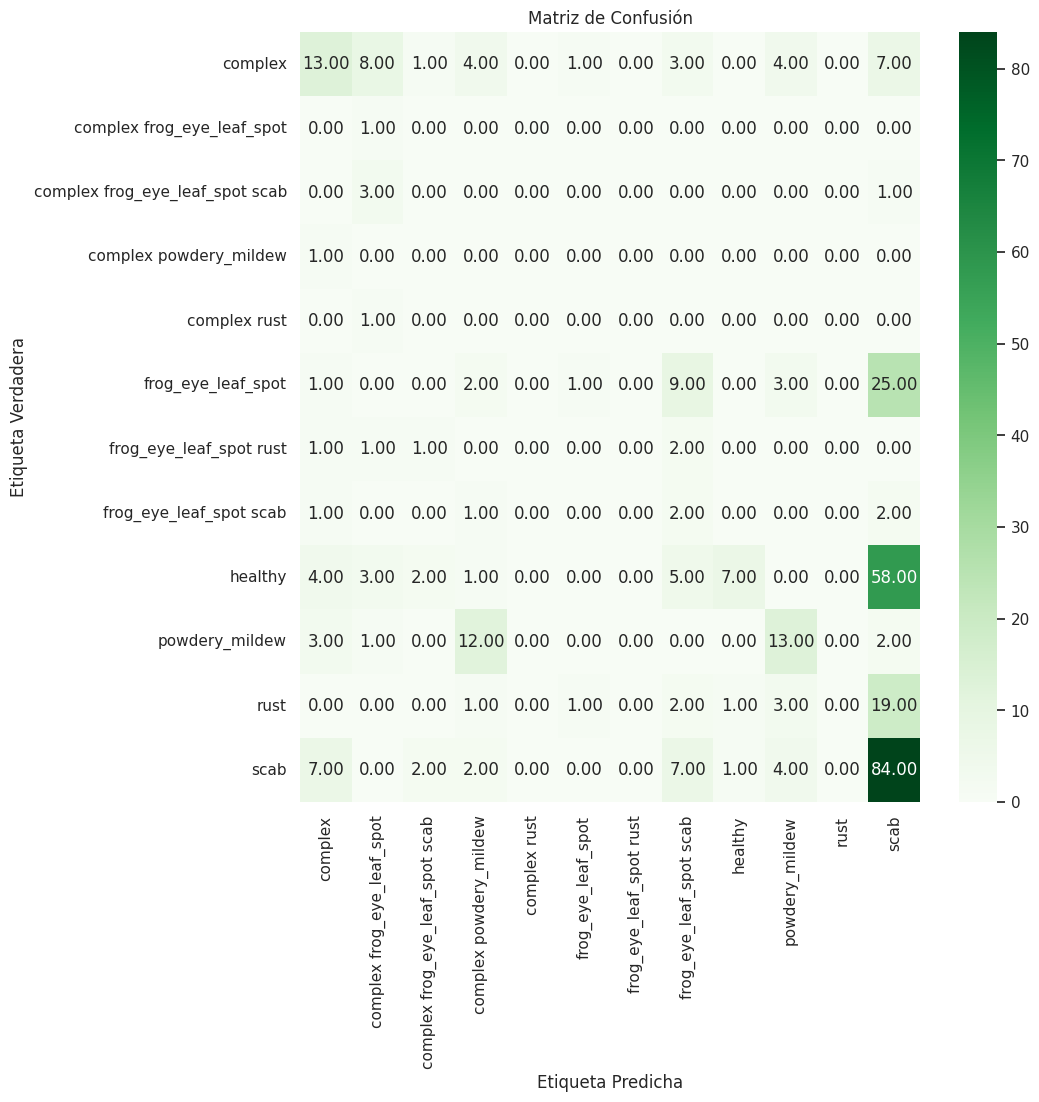

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configura la figura y los ejes
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)  # Ajusta el tamaño de la fuente para las etiquetas de los ejes
sns.heatmap(cm, annot=True, cmap='Greens', fmt='.2f', xticklabels=classes, yticklabels=classes)

# Configura los títulos y las etiquetas de los ejes
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')

# Muestra la gráfica
plt.show()